# Time Series Decomposition & Analysis Assignment

In [3]:
import pandas as pd
import statsmodels.api as sm
import plotly.express as px

### Import the monthly sunspots data set into a Pandas dataframe, and convert the Month field to a datetime data type.

In [4]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%203/monthly-sunspots.csv')

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     2820 non-null   object 
 1   Sunspots  2820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [34]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Month     2820 non-null   datetime64[ns]
 1   Sunspots  2820 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.2 KB


,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0


### Use a line chart to plot the time series.

In [35]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, 
                  template='none').update(layout=dict(title=dict(x=0.5)))

    fig.show()

In [36]:
ilinechart(df, 'Month','Sunspots',title='Sunspots from 1749 to 1983')

### Decompose the time series and add columns for the trend, seasonality, and residuals to the data set.

In [37]:
series = df.set_index('Month')
series

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


In [40]:
decomposition = sm.tsa.seasonal_decompose(series, model='additive', freq=120)

In [41]:
trend = decomposition.trend.reset_index()
seasonality = decomposition.seasonal.reset_index()
residuals = decomposition.resid.reset_index()

### Plot the observed values, trend, seasonality, and residuals on a multi-line chart. You should have a line for each column.

**Hint:** You may need to melt the data so that all the categories are in a single column and all the values are in a single column.

In [42]:
merged = df.merge(trend, on='Month')
merged = merged.merge(seasonality, on='Month')
merged = merged.merge(residuals, on='Month')
merged.columns = ['Month', 'Observed', 'Trend', 'Seasonality', 'Residuals']

In [44]:
merged.head()

,Month,Observed,Trend,Seasonality,Residuals
0,1749-01-01,58.0,NaN,21.880705,NaN
1,1749-02-01,62.6,NaN,23.866576,NaN
2,1749-03-01,70.0,NaN,19.885780,NaN
3,1749-04-01,55.7,NaN,19.890667,NaN
4,1749-05-01,85.0,NaN,20.209341,NaN


In [45]:
melted = pd.melt(merged, 
                 id_vars='Month', 
                 value_vars=['Observed', 'Trend', 'Seasonality', 'Residuals'], 
                 var_name='Variable', 
                 value_name='Value')

melted.head()

,Month,Variable,Value
0,1749-01-01,Observed,58.0
1,1749-02-01,Observed,62.6
2,1749-03-01,Observed,70.0
3,1749-04-01,Observed,55.7
4,1749-05-01,Observed,85.0


In [47]:
melted.tail()

,Month,Variable,Value
11275,1983-08-01,Residuals,NaN
11276,1983-09-01,Residuals,NaN
11277,1983-10-01,Residuals,NaN
11278,1983-11-01,Residuals,NaN
11279,1983-12-01,Residuals,NaN


In [46]:
ilinechart(melted, 'Month', 'Value', groups='Variable', title='Observed vs Components')

### Add two columns to the data set - one that calculates a rolling mean and another that calculates a rolling standard deviation.

In [48]:
merged['Rolling_Mean'] = merged['Observed'].rolling(window=120).mean()
merged['Rolling_Std'] = merged['Observed'].rolling(window=120).std()

### Plot the rolling mean and standard deviation on a multi-line chart along with the observed values.

In [49]:
melted = pd.melt(merged, 
                 id_vars='Month', 
                 value_vars=['Observed', 'Rolling_Mean', 'Rolling_Std'], 
                 var_name='Variable', 
                 value_name='Value')

ilinechart(melted, 'Month', 'Value', groups='Variable', title='Rolling Mean & Standard Deviation')

### Perform an Augmented Dickey Fuller Test on the data set and determine whether this time series is stationary.

In [50]:
adf_test = sm.tsa.stattools.adfuller(merged['Observed'])

adf_test

(-9.567667511913076,
 2.333452143866306e-16,
 27,
 2792,
 {'1%': -3.432694313168895,
  '10%': -2.5673213632123297,
  '5%': -2.862575752726396},
 23141.276837258665)

In [51]:
results = pd.Series(adf_test[0:4], 
                    index=['ADF Test Statistic',
                            'P-Value', 
                            '# Lags Used',
                            '# Observations Used'])
results

ADF Test Statistic    -9.567668e+00
P-Value                2.333452e-16
# Lags Used            2.700000e+01
# Observations Used    2.792000e+03
dtype: float64

In [52]:
for key, value in adf_test[4].items():
  results[f'Critical Value {key}'] = value

In [53]:
print(results)

ADF Test Statistic    -9.567668e+00
P-Value                2.333452e-16
# Lags Used            2.700000e+01
# Observations Used    2.792000e+03
Critical Value 1%     -3.432694e+00
Critical Value 5%     -2.862576e+00
Critical Value 10%    -2.567321e+00
dtype: float64


### Generate an autocorrelation plot for the data set to determine the level of autocorrelation in this time series.

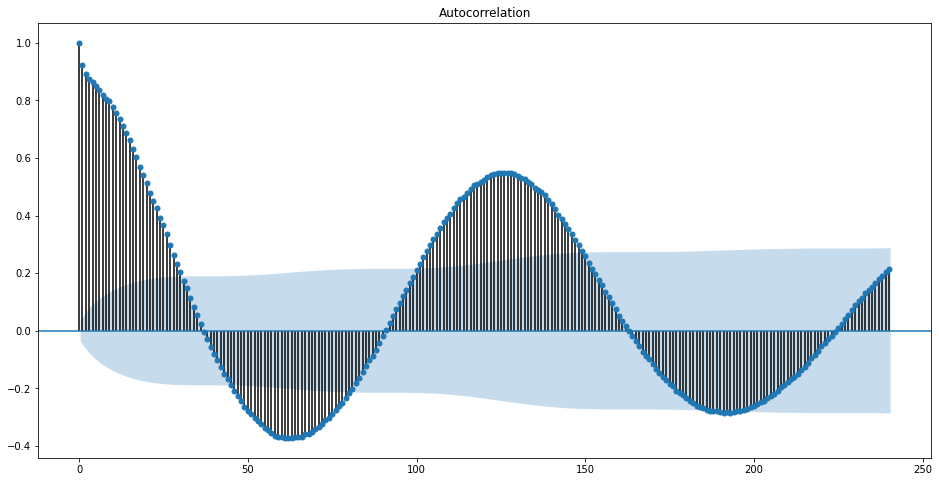

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

series = df.set_index('Month')
fig = plot_acf(series, lags=240)